In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def relu(a):
    return np.maximum(0,a)

In [3]:
def sig(a):
    a=np.array(a,dtype=np.float128)
    return 1.0/(1.0+np.exp(-a))

In [4]:
def derSig(a):
#     a=np.array(a,dtype=np.float128)
    return sig(a)*(1-sig(a))

In [5]:
def softMax(a):
    a=np.array(a,dtype=np.float128)
    a=np.exp(a)
    if np.sum!=0:
        a=a/np.sum(a)
    return a

In [6]:
def derRelu(a):
    a=a.T[0]
    for i in range(len(a)):
        if a[i]<=0:
            a[i]=0
        else:
            a[i]=1
            
    return np.reshape(a,(len(a),1))

In [7]:
def derFunc(func,a):
    if func==sig:
        return derSig(a)
    elif func==relu:
        return derRelu(a)
    elif func==softMax:
        return a

In [8]:
# data=pd.read_csv('2017EE10544.csv',header=None)
# data=np.array(data)
# n=3000
# m=784
# x=data[0:n,0:m]
# t=data[0:n,784:785]
# x=np.array(x)
# x=x/1000
# t=np.array(t)

In [69]:
data=pd.read_csv('2017EE10544PCA.csv',header=None)
data=np.array(data)
n=3000
m=25
x=data[0:n,0:m]
t=data[0:n,25:26]
x=np.array(x)
x=x/np.max(x)
t=np.array(t)

In [9]:
def backProp(x1,t1,weights,biases,lengths,func):
    layers=len(lengths)
    answer=np.zeros((10,1))
    answer[t1[0]][0]=1
    a=[np.zeros((y, 1)) for y in lengths]
    z=[np.zeros((y, 1)) for y in lengths]
    delta=[np.zeros((y, 1)) for y in lengths]
    sig_der=[np.zeros((y, 1)) for y in lengths]
    a[0]=np.reshape(x1,(len(x1),1))
    
    for i in range(1,layers):
#         if i==layers-1:
#             func=softMax
        z[i]=np.dot(weights[i-1],a[i-1])+biases[i-1]
        a[i]=func[i-1](z[i])
        sig_der[i]=derFunc(func[i-1],z[i])

#     delta[layers-1]=np.diag(sig_der[layers-1].T[0]).dot(a[layers-1]-answer)
    delta[layers-1]=a[layers-1]-answer

    for i in range(2,layers):
        delta[layers-i]=np.diag(sig_der[layers-i].T[0]).dot(weights[layers-i].T.dot(delta[layers-i+1]))
        
    return (delta,a)    

In [10]:
def update(x_train,t_train,itr,weights,biases,lengths,func,eta,lamda):
    layers=len(lengths)
    l=len(x_train)
    for i in range(itr):
        temp=backProp(x_train[i%l],t_train[i%l],weights,biases,lengths,func)
        delta=temp[0]
        a=temp[1]
        for j in range(1,layers):
            for k in range(weights[j-1].shape[0]):
                weights[j-1][k]=weights[j-1][k]*(1-eta*lamda)-a[j-1].T[0]*delta[j][k][0]*eta
                biases[j-1][k]-=delta[j][k][0]*eta
        
    return (weights,biases)

In [11]:
def miniUpdate(x_train,t_train,itr,size,weights,biases,lengths,func,eta,lamda):
    layers=len(lengths)
    l=len(x_train)

    for i in range(itr):
        for v in range(size):
            temp=backProp(x_train[(i*size+v)%l],t_train[(i*size+v)%l],weights,biases,lengths,func)
            delta=temp[0]
            a=temp[1]
            for j in range(1,layers):
                for k in range(weights[j-1].shape[0]):
                    weights[j-1][k]=weights[j-1][k]*(1-eta*lamda)-a[j-1].T[0]*delta[j][k][0]*eta
                    biases[j-1][k]-=delta[j][k][0]*eta            

    return (weights,biases)

In [12]:
def neuralNet(x_train,t_train,lengths,func,eta,lamda,batchsize,itr):
    np.random.seed(0)
    biases = [np.random.randn(y, 1) for y in lengths[1:]]
    weights = [np.random.randn(y, x) for x, y in zip(lengths[:-1], lengths[1:])]
    
#     temp=update(x_train,t_train,40000,weights,biases,lengths,func,eta,lamda)
    temp=miniUpdate(x_train,t_train,itr,batchsize,weights,biases,lengths,func,eta,lamda)
    return temp

In [13]:
def helper(x1,weights,biases,lengths,func):
    layers=len(lengths)
    a=np.reshape(x1,(len(x1),1))
#     print(a)
    for i in range(1,layers):
#         if i==layers-1:
#             func=softMax
        w=weights[i-1]
        b=biases[i-1]
        a=func[i-1](np.dot(w,a)+b)
    return np.argmax(a)

In [14]:
def predict(x_test,weights,biases,lengths,func):
    prediction=[]
    for i in range(len(x_test)):
        prediction.append(helper(x_test[i],weights,biases,lengths,func))
    return np.array(prediction)

In [15]:
def accuracy(y_pred,t_test):
    a=0
    k=len(t_test)
    for i in range(k):
        if y_pred[i]==t_test[i]:
            a=a+1
    return a/k

In [16]:
def crossAccuracy(folds,lengths,func,eta,lamda,batchsize,itr):
    b=n//folds
    ac=0
    y=[]
    y1=[]
    f=0
    for i in range(folds):
        temp=np.array(x[f:f+b,0:m])
        temp1=np.array(t[f:f+b])
        f=f+b
        y.append(temp)
        y1.append(temp1)
    
    for i in range(folds):
        x_test=y[i]
        t_test=y1[i]
        x_train=np.reshape([],(0,m))
        t_train=np.reshape([],(0,1))
        
        for j in range(folds):
            if i!=j:
                x_train=np.concatenate((x_train,y[j]),axis=0)
                t_train=np.concatenate((t_train,y1[j]),axis=0)
                

#         print(t_train)
#         print(t_test)
        t_train=np.array((t_train),dtype=int)
        t_test=np.array(t_test,dtype=int)
        network=neuralNet(x_train,t_train,lengths,func,eta,lamda,batchsize,itr)
        k=accuracy(predict(x_test,network[0],network[1],lengths,func),t_test.T[0])
#         print(k)
        ac+=k
        break
        
    return ac

In [97]:
crossAccuracy(4,[m,10],[softMax],0.01,0,1,40000)

0.8186666666666667

In [32]:
network=neuralNet(x,t,[m,100,200,10],[sig,relu,softMax],0.1,0,1,40000) 
print(accuracy(predict(x,network[0],network[1],[m,100,200,10],[sig,relu,softMax]),t.T[0]))

In [44]:
x_test=x[0:750]
t_test=t[0:750]
network=neuralNet(x[750:3000],t[750:3000],[m,100,200,10],[sig,sig,softMax],0.2,0,1,40000) 

In [45]:
y_pred=predict(x_test,network[0],network[1],[m,100,200,10],[sig,sig,softMax])

In [47]:
t_test=t_test.T[0]

In [48]:
misclass=np.zeros(10)
misx=[]
misy=[]
misPred=[]
for i in range(x_test.shape[0]):
    if t_test[i]!=y_pred[i]:
        misx.append(x_test[i])
        misy.append(t_test[i])
        misPred.append(y_pred[i])
        misclass[t_test[i]]+=1

<BarContainer object of 10 artists>

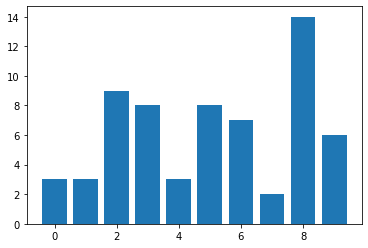

In [49]:
plt.bar(range(10),misclass)

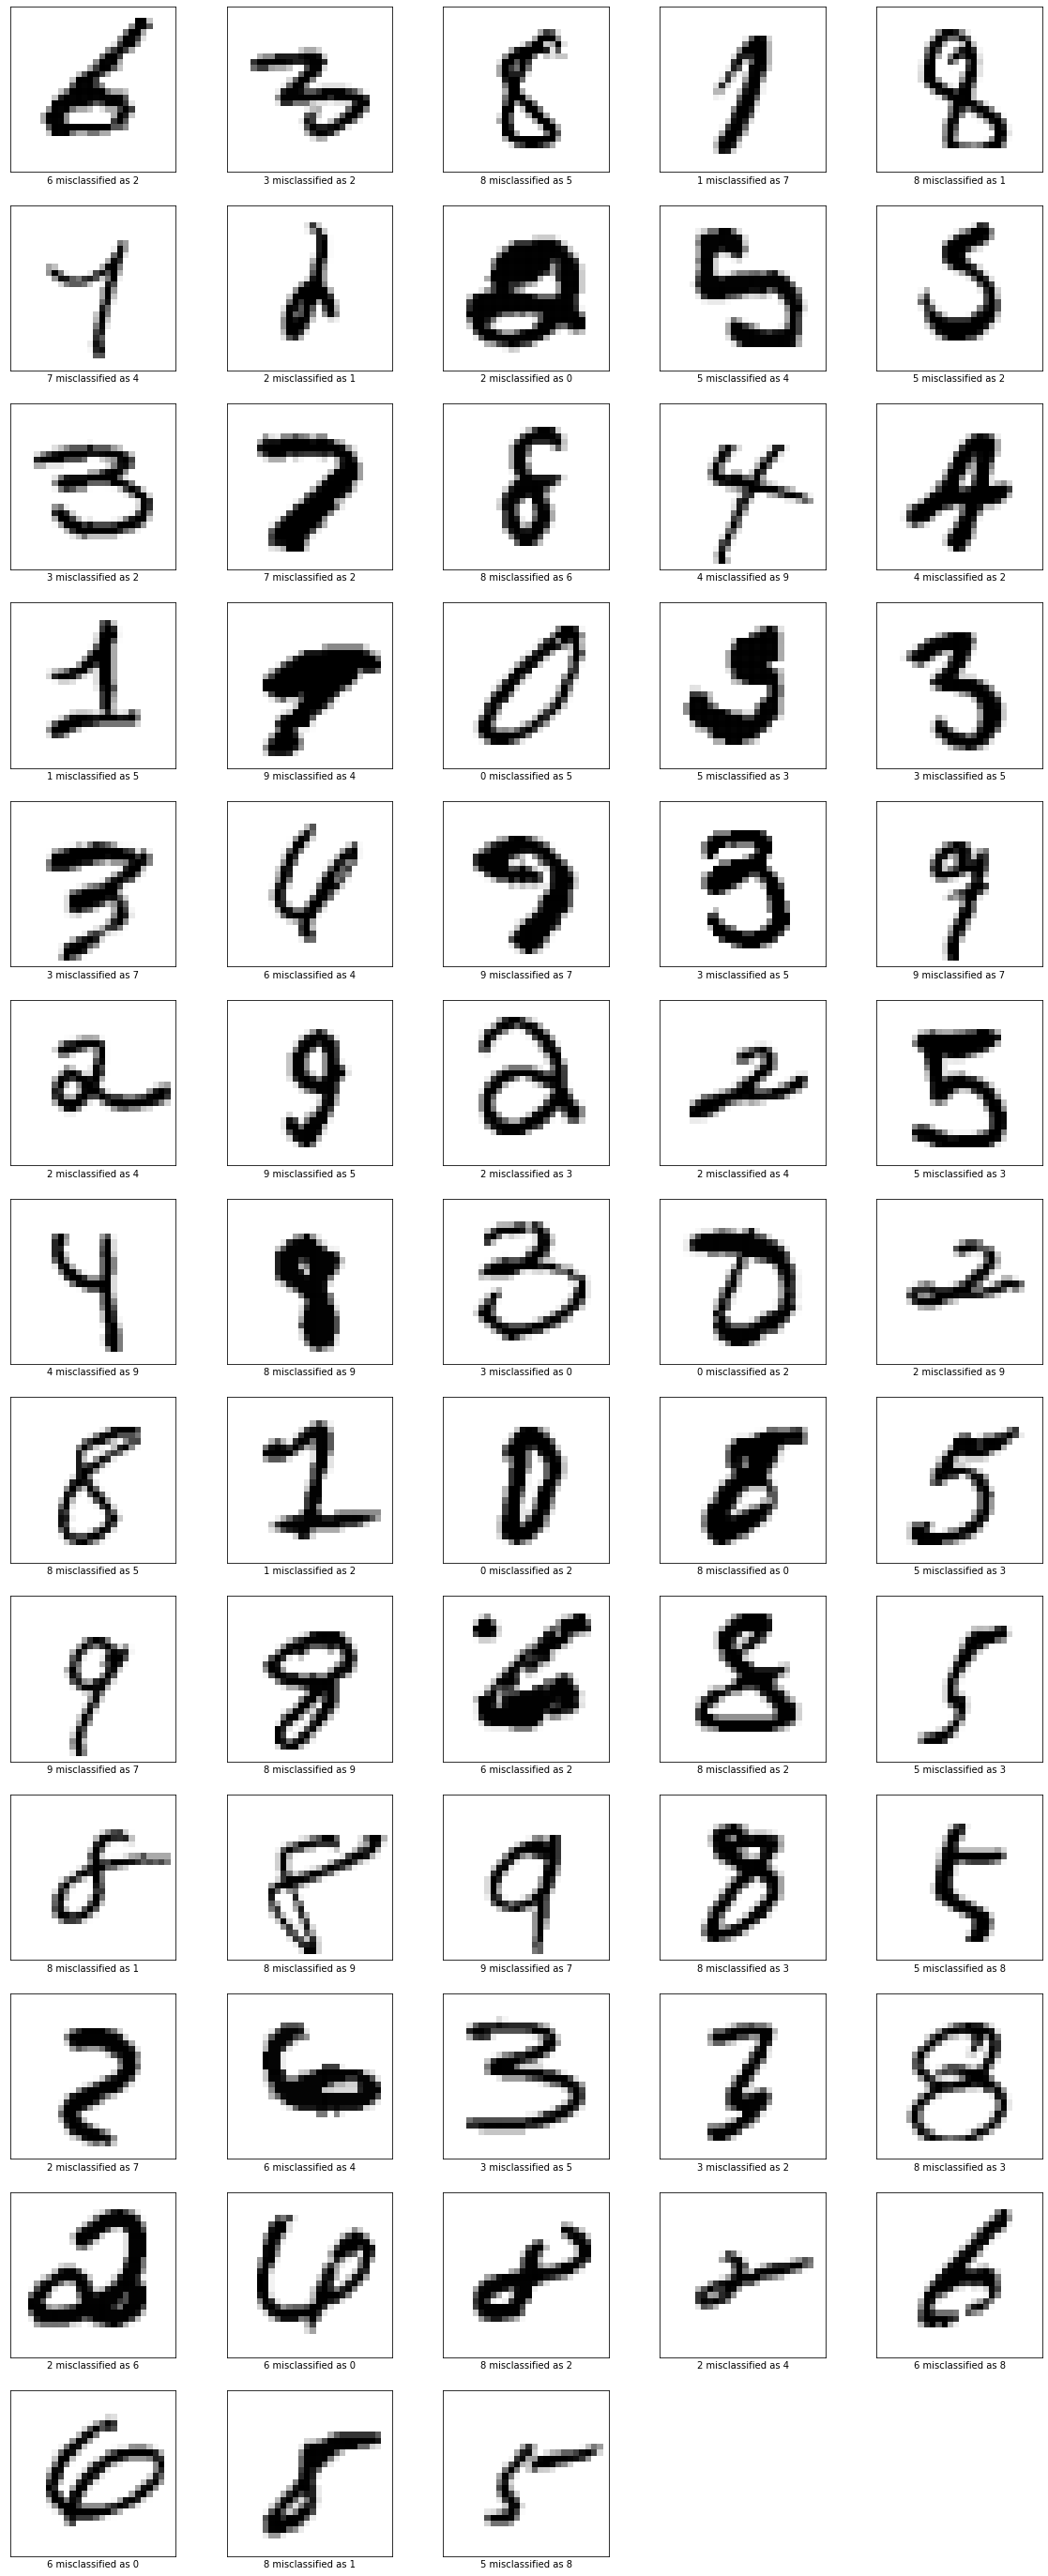

In [55]:
plt.figure(figsize=(20,50))
for i in range(len(misx)):
    plt.subplot(len(misx)//5+1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(misx[i],(28,28)).T, cmap=plt.cm.binary)
    plt.xlabel(str(misy[i])+' misclassified as '+str(misPred[i]))
plt.savefig('missclassified.png')
plt.show()

In [98]:
def plot(folds,func,eta,lamda,batchsize,itr):
    x1=np.linspace(0.01,0.1,10)
    y1=[]
    for i in x1:
        temp=crossAccuracy(4,[m,10],func,i,lamda,batchsize,itr)
        y1.append(temp)
        print(i,temp)  
    plt.plot(x1,y1)
    plt.xlabel('Learning Rate')
    plt.ylabel('Cross-Validation Accuracy')
    return x1,y1

In [60]:
def plot2(folds,func,eta,lamda,batchsize,itr):
    x1=[60,100,200]
    x2=[60,100,200]
    y1=[]
    for i in x1:
        for j in x2:
            temp=crossAccuracy(4,[m,int(i),int(j),10],func,eta,lamda,batchsize,itr)
#         y1.append(temp)
            print(i,j,temp)  
#     plt.plot(x1,y1)
#     plt.xlabel('Neurons in Hidden Layer')
#     plt.ylabel('Cross-Validation Accuracy')
    return x1,y1

0.01 0.8186666666666667
0.020000000000000004 0.844
0.030000000000000006 0.8653333333333333
0.04000000000000001 0.872
0.05000000000000001 0.8746666666666667
0.06000000000000001 0.8746666666666667
0.07 0.8746666666666667
0.08 0.8746666666666667
0.09000000000000001 0.8733333333333333
0.1 0.8786666666666667


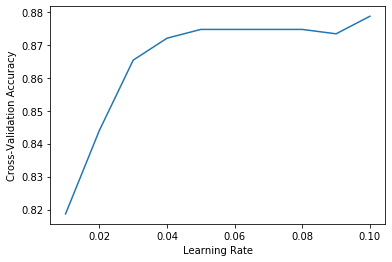

In [99]:
temp=plot(4,[softMax],0.5,0,1,40000)